<a href="https://colab.research.google.com/github/sayanbanerjee32/TASI_ERAv2_S9/blob/main/S9_SayanBanerjee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all required packages including local files

In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np

#import from local modules
from utils import train, test, get_device, plot_accuracy_losses, plot_top_loss
# from models import Net

# Check if GPU available

In [18]:
# CUDA? - call get_device function defined in utils.py
is_cuda, device = get_device()

CUDA Available? True


# Visualising Train data

# Dataset and Creating Train/Test Split

In [19]:
train_data_raw = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [20]:
# train data shape
print(train_data_raw.data.shape)
# train data mean
print(train_data_raw.data.mean(axis=(0,1,2))/255)
# train data standard deviation
print(train_data_raw.data.std(axis=(0,1,2))/255)

(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]


# Dataloader Arguments & Test/Train Dataloaders

In [21]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if is_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader_raw = torch.utils.data.DataLoader(train_data_raw, **dataloader_args)

class_labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

## Data Visualization

torch.Size([128, 3, 32, 32])
torch.Size([128])


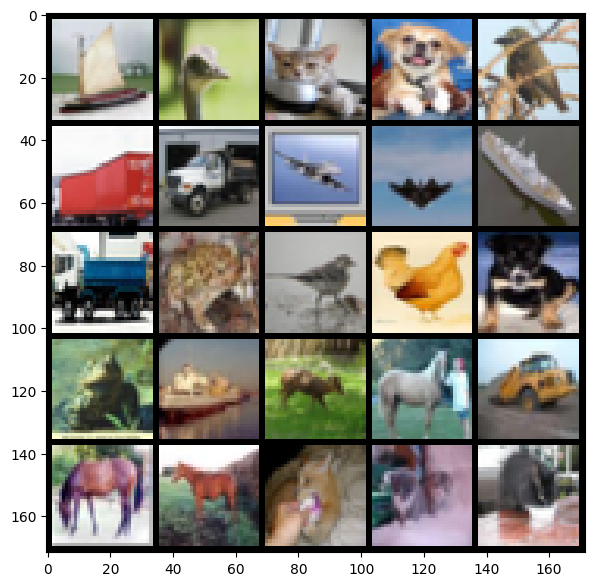

In [22]:
dataiter = iter(train_loader_raw)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

In [23]:
# how labels look like
print(' '.join(f'{class_labels[labels[j]]:5s}' for j in range(len(labels[:25]))))

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat  


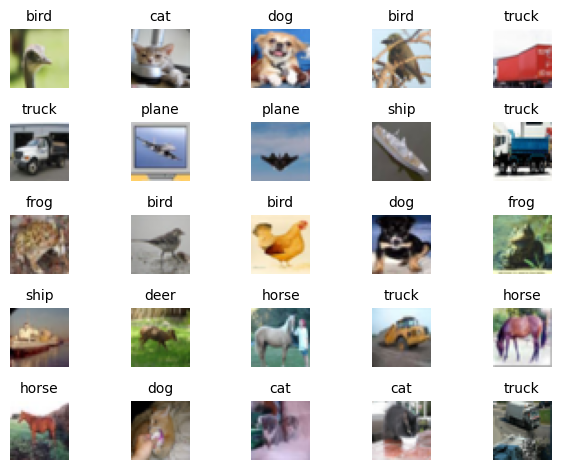

In [24]:
figure = plt.figure()
rows, cols = 5, 5
for index in range(1, cols * rows  + 1):
    plt.subplot(rows, cols, index)
    plt.title(class_labels[labels[index]],fontsize = 10)
    plt.axis('off')
    plt.imshow(images[index].permute(1, 2, 0))
figure.tight_layout()
plt.show()

# Train and Test transformations

In [25]:
class Cifar10Dataset(datasets.CIFAR10):
    def __init__(self, root = './data', train=True, download=True, transform=None):
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __getitem__(self, index):
        image, label = self.data[index], self.targets[index]

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image, label

In [26]:
# Train Phase transformations
train_transforms = A.Compose([
                                A.HorizontalFlip(p=0.5),
                                A.ShiftScaleRotate(shift_limit=0.8, scale_limit=1.4, rotate_limit=360, p=0.5),
                                A.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.262)),
                                A.CoarseDropout(max_holes = 1, max_height=16, max_width=16, min_holes = 1, min_height=16, min_width=16,
                                                fill_value=[0.4914,0.4822,0.4465], mask_fill_value = None),
                                ToTensorV2(),
                                ])

# Test Phase transformations
test_transforms = A.Compose([
                            A.Normalize((0.4914,0.4822,0.4465), (0.247,0.243,0.262)),
                            ToTensorV2(),
                            ])

# Dataset and Creating Train/Test Split

In [27]:
# train_data = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
# test_data = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)
train_data = Cifar10Dataset(transform=train_transforms)
test_data = Cifar10Dataset(train=False, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
train_data

Dataset Cifar10Dataset
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose([
             HorizontalFlip(always_apply=False, p=0.5),
             ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.8, 0.8), shift_limit_y=(-0.8, 0.8), scale_limit=(-1.4, 1.4), rotate_limit=(-360, 360), interpolation=1, border_mode=4, value=None, mask_value=None, rotate_method='largest_box'),
             Normalize(always_apply=False, p=1.0, mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.262), max_pixel_value=255.0),
             CoarseDropout(always_apply=False, p=0.5, max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=[0.4914, 0.4822, 0.4465], mask_fill_value=None),
             ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
           ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)

# Dataloader Arguments & Test/Train Dataloaders

In [29]:
# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

### Augmented data visualization

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([128, 3, 32, 32])
torch.Size([128])


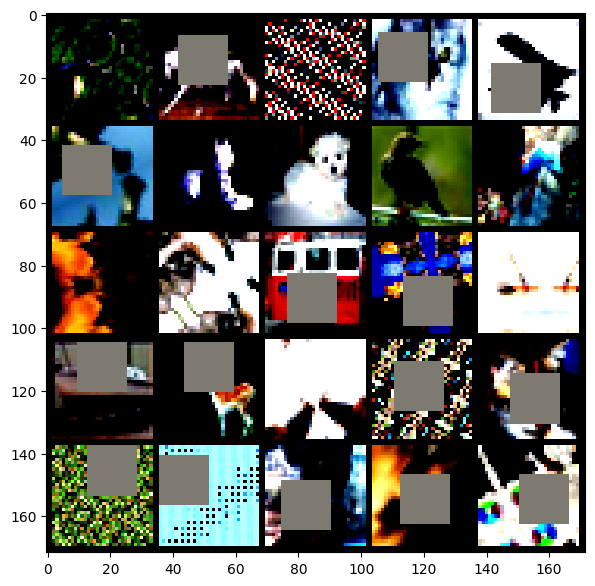

In [39]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Create a grid of images
grid = torchvision.utils.make_grid(images[:25], nrow=5)

# Display the grid
plt.figure(figsize=(7,7))
plt.imshow(grid.permute(1,2,0))
plt.show()

# Training

In [60]:
class Net(nn.Module):
    def __init__(self, dropout_value = 0.1):
        super(Net, self).__init__()
        # # Input Block / CONVOLUTION BLOCK 1
        self.C1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 32 x 32 x 3, output size: 32 x 32 x n*2, receptive field: 1 + (3-1) * 1 = 3


        self.C2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 32 x 32 x n*2, output size: 24 x 24 x n*4, receptive field: 3 + (3-1) * 1 = 5

        ## Strided convolution
        self.SC1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=(3, 3), padding=1, stride = 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 32 x 32 x n*2, output size: 24 x 24 x n*4, receptive field: 3 + (3-1) * 1 = 5

        # TRANSITION BLOCK 1
        self.t1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 32 x 32 x n*4, output size: 32 x 32 x n, receptive field: 6 + (1-1)*2 = 6


        # CONVOLUTION BLOCK 2
        self.C3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n, output size: 16 x 16 x n*2, receptive field: 6 + (3-1) * 2 = 10

        self.C4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14

        self.SC2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=(3, 3), padding=1, stride = 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n*4, receptive field: 14 + (3-1) * 2 = 18

        # TRANSITION BLOCK 2
        self.t2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n, receptive field: 18 + (1-1)*2 = 18

        # CONVOLUTION BLOCK 3
        self.C5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n, output size: 16 x 16 x n*2, receptive field: 6 + (3-1) * 2 = 10

        self.C6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*2, output size: 16 x 16 x n*4, receptive field: 10 + (3-1) * 2 = 14

        self.SC3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=(3, 3), padding=1, stride = 2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n*4, receptive field: 14 + (3-1) * 2 = 18

        # TRANSITION BLOCK 3
        self.t3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32,
                      kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) #input size: 16 x 16 x n*4, output size: 16 x 16 x n, receptive field: 18 + (1-1)*2 = 18

        # CONVOLUTION BLOCK 4
        self.C7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n, output size: 8 x 8 x n*2, receptive field: 20 + (3-1) * 4 = 28

        self.C8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        ) #input size: 8 x 8 x n*2, output size: 8 x 8 x n*4, receptive field: 28 + (3-1) * 4 = 36

        # self.C10 = nn.Sequential(
        #     nn.Conv2d(in_channels=n*4, out_channels=n*4,
        #               kernel_size=(3, 3), padding=1, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(n*4),
        #     nn.Dropout(dropout_value)
        # ) #input size: 8 x 8 x n*4, output size: 8 x 8 x n*4, receptive field: 36 + (3-1) * 4 = 44

        # OUTPUT BLOCK
        self.GAP = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1))
        ) #input size: 8 x 8 x n*4, output size: 1 x 1 x n*4, receptive field: 44

        self.c11 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=10,
                      kernel_size=(1, 1), padding=0, bias=False),
        ) #input size: 1 x 1 x n*4, output size: 1 x 1 x 10, receptive field: 44 + (1-1) * 4 =44



    def forward(self, x):
        x = self.C1(x)
        x = self.C2(x)

        x = self.SC1(x)
        x = self.t1(x)

        x = self.C3(x)
        x = self.C4(x)

        x = self.SC2(x)
        x = self.t2(x)

        x = self.C5(x)
        x = self.C6(x)

        x = self.SC3(x)
        x = self.t3(x)

        x = self.C7(x)
        x = self.C8(x)

        x = self.GAP(x)
        x = self.c11(x)

        x = x.squeeze()

        return F.log_softmax(x, dim=-1)

In [61]:
# visualise model parameters
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 16, 16]          36,864
             ReLU-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
          Dropout-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 32, 16, 16]           2,048
             ReLU-14           [-1, 32,

In [62]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [63]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

def resume(model, filename):
    model.load_state_dict(torch.load(filename))

In [64]:
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer  = optimizer,
                                                 mode = 'min',
                                                 factor = 0.1,
                                                 min_lr = 0.0001,
                                                 threshold_mode  = 'rel',
                                                 threshold = 0.0001,
                                                 patience  = 2,
                                                 verbose = True)
criterion = F.nll_loss
num_epochs = 100
early_stopping_patience = 5
best_test_loss = np.inf
best_epoch = -1
for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    # call train function from utils.py
    trn_acc, trn_loss = train(model, device, train_loader, optimizer, criterion)
    # accumulate train accuracies and test losses for visualisation
    train_acc.append(trn_acc)
    train_losses.append(trn_loss)

    # call test function from utils.py
    tst_acc, tst_loss = test(model, device, test_loader, criterion)
    # accumulate test accuracies and test losses for visualisation
    test_acc.append(tst_acc)
    test_losses.append(tst_loss)

    scheduler.step(tst_loss)
    # early stopping
    if tst_loss < best_test_loss:
        best_test_loss = tst_loss
        best_epoch = epoch
        checkpoint(model, "best_model.pth")
    elif epoch - best_epoch > early_stopping_patience:
        print("Early stopped training at epoch %d" % epoch)
        break  # terminate the training loop

resume(model, "best_model.pth")

Epoch 1


Train: Loss=1.8810 Batch_id=390 Accuracy=25.30: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s]


Test set: Average loss: 1.7655, Accuracy: 3489/10000 (34.89%)

Epoch 2


Train: Loss=1.7800 Batch_id=390 Accuracy=30.74: 100%|██████████| 391/391 [00:17<00:00, 22.79it/s]


Test set: Average loss: 1.5609, Accuracy: 4279/10000 (42.79%)

Epoch 3


Train: Loss=1.8839 Batch_id=390 Accuracy=33.19: 100%|██████████| 391/391 [00:17<00:00, 22.04it/s]


Test set: Average loss: 1.4699, Accuracy: 4660/10000 (46.60%)

Epoch 4


Train: Loss=1.7307 Batch_id=390 Accuracy=35.21: 100%|██████████| 391/391 [00:17<00:00, 22.63it/s]


Test set: Average loss: 1.4508, Accuracy: 4726/10000 (47.26%)

Epoch 5


Train: Loss=1.8734 Batch_id=390 Accuracy=36.91: 100%|██████████| 391/391 [00:17<00:00, 22.72it/s]


Test set: Average loss: 1.3445, Accuracy: 5036/10000 (50.36%)

Epoch 6


Train: Loss=1.6668 Batch_id=390 Accuracy=38.62: 100%|██████████| 391/391 [00:17<00:00, 22.77it/s]


Test set: Average loss: 1.2905, Accuracy: 5212/10000 (52.12%)

Epoch 7


Train: Loss=1.5141 Batch_id=390 Accuracy=40.11: 100%|██████████| 391/391 [00:17<00:00, 22.86it/s]


Test set: Average loss: 1.2049, Accuracy: 5721/10000 (57.21%)

Epoch 8


Train: Loss=1.7674 Batch_id=390 Accuracy=41.34: 100%|██████████| 391/391 [00:17<00:00, 22.63it/s]


Test set: Average loss: 1.1177, Accuracy: 6037/10000 (60.37%)

Epoch 9


Train: Loss=1.5609 Batch_id=390 Accuracy=42.41: 100%|██████████| 391/391 [00:17<00:00, 22.93it/s]


Test set: Average loss: 1.0777, Accuracy: 6164/10000 (61.64%)

Epoch 10


Train: Loss=1.4630 Batch_id=390 Accuracy=43.87: 100%|██████████| 391/391 [00:17<00:00, 21.77it/s]


Test set: Average loss: 1.0944, Accuracy: 6154/10000 (61.54%)

Epoch 11


Train: Loss=1.4605 Batch_id=390 Accuracy=44.53: 100%|██████████| 391/391 [00:17<00:00, 22.69it/s]


Test set: Average loss: 0.9752, Accuracy: 6533/10000 (65.33%)

Epoch 12


Train: Loss=1.5277 Batch_id=390 Accuracy=45.52: 100%|██████████| 391/391 [00:18<00:00, 21.39it/s]


Test set: Average loss: 0.9546, Accuracy: 6569/10000 (65.69%)

Epoch 13


Train: Loss=1.4114 Batch_id=390 Accuracy=46.43: 100%|██████████| 391/391 [00:17<00:00, 22.82it/s]


Test set: Average loss: 0.8938, Accuracy: 6860/10000 (68.60%)

Epoch 14


Train: Loss=1.5404 Batch_id=390 Accuracy=47.06: 100%|██████████| 391/391 [00:17<00:00, 21.80it/s]


Test set: Average loss: 0.8690, Accuracy: 7000/10000 (70.00%)

Epoch 15


Train: Loss=1.3006 Batch_id=390 Accuracy=47.68: 100%|██████████| 391/391 [00:16<00:00, 23.04it/s]


Test set: Average loss: 0.8391, Accuracy: 6966/10000 (69.66%)

Epoch 16


Train: Loss=1.3020 Batch_id=390 Accuracy=48.23: 100%|██████████| 391/391 [00:18<00:00, 21.35it/s]


Test set: Average loss: 0.8048, Accuracy: 7207/10000 (72.07%)

Epoch 17


Train: Loss=1.2926 Batch_id=390 Accuracy=49.24: 100%|██████████| 391/391 [00:17<00:00, 22.70it/s]


Test set: Average loss: 0.8302, Accuracy: 7139/10000 (71.39%)

Epoch 18


Train: Loss=1.5751 Batch_id=390 Accuracy=49.61: 100%|██████████| 391/391 [00:17<00:00, 21.76it/s]


Test set: Average loss: 0.7915, Accuracy: 7212/10000 (72.12%)

Epoch 19


Train: Loss=1.5262 Batch_id=390 Accuracy=50.09: 100%|██████████| 391/391 [00:17<00:00, 22.77it/s]


Test set: Average loss: 0.7506, Accuracy: 7423/10000 (74.23%)

Epoch 20


Train: Loss=1.3004 Batch_id=390 Accuracy=51.00: 100%|██████████| 391/391 [00:17<00:00, 22.58it/s]


Test set: Average loss: 0.7461, Accuracy: 7457/10000 (74.57%)

Epoch 21


Train: Loss=1.4052 Batch_id=390 Accuracy=51.41: 100%|██████████| 391/391 [00:17<00:00, 22.77it/s]


Test set: Average loss: 0.7148, Accuracy: 7539/10000 (75.39%)

Epoch 22


Train: Loss=1.3407 Batch_id=390 Accuracy=51.79: 100%|██████████| 391/391 [00:17<00:00, 22.61it/s]


Test set: Average loss: 0.7234, Accuracy: 7534/10000 (75.34%)

Epoch 23


Train: Loss=1.2444 Batch_id=390 Accuracy=52.28: 100%|██████████| 391/391 [00:17<00:00, 22.75it/s]


Test set: Average loss: 0.6765, Accuracy: 7660/10000 (76.60%)

Epoch 24


Train: Loss=1.3838 Batch_id=390 Accuracy=52.29: 100%|██████████| 391/391 [00:17<00:00, 22.98it/s]


Test set: Average loss: 0.6586, Accuracy: 7737/10000 (77.37%)

Epoch 25


Train: Loss=1.2900 Batch_id=390 Accuracy=52.84: 100%|██████████| 391/391 [00:17<00:00, 22.36it/s]


Test set: Average loss: 0.6755, Accuracy: 7695/10000 (76.95%)

Epoch 26


Train: Loss=1.2582 Batch_id=390 Accuracy=53.06: 100%|██████████| 391/391 [00:17<00:00, 22.58it/s]


Test set: Average loss: 0.6467, Accuracy: 7795/10000 (77.95%)

Epoch 27


Train: Loss=1.2148 Batch_id=390 Accuracy=53.61: 100%|██████████| 391/391 [00:18<00:00, 21.42it/s]


Test set: Average loss: 0.6209, Accuracy: 7854/10000 (78.54%)

Epoch 28


Train: Loss=1.1767 Batch_id=390 Accuracy=53.71: 100%|██████████| 391/391 [00:17<00:00, 22.60it/s]


Test set: Average loss: 0.6202, Accuracy: 7922/10000 (79.22%)

Epoch 29


Train: Loss=1.4468 Batch_id=390 Accuracy=53.89: 100%|██████████| 391/391 [00:18<00:00, 21.37it/s]


Test set: Average loss: 0.6025, Accuracy: 7986/10000 (79.86%)

Epoch 30


Train: Loss=1.2727 Batch_id=390 Accuracy=54.51: 100%|██████████| 391/391 [00:17<00:00, 22.84it/s]


Test set: Average loss: 0.6231, Accuracy: 7878/10000 (78.78%)

Epoch 31


Train: Loss=1.3200 Batch_id=390 Accuracy=54.95: 100%|██████████| 391/391 [00:17<00:00, 22.07it/s]


Test set: Average loss: 0.5916, Accuracy: 7989/10000 (79.89%)

Epoch 32


Train: Loss=1.4558 Batch_id=390 Accuracy=54.99: 100%|██████████| 391/391 [00:17<00:00, 22.99it/s]


Test set: Average loss: 0.5838, Accuracy: 8031/10000 (80.31%)

Epoch 33


Train: Loss=1.1457 Batch_id=390 Accuracy=55.43: 100%|██████████| 391/391 [00:17<00:00, 22.41it/s]


Test set: Average loss: 0.5782, Accuracy: 8025/10000 (80.25%)

Epoch 34


Train: Loss=1.2238 Batch_id=390 Accuracy=55.53: 100%|██████████| 391/391 [00:17<00:00, 22.41it/s]


Test set: Average loss: 0.5905, Accuracy: 7996/10000 (79.96%)

Epoch 35


Train: Loss=1.0467 Batch_id=390 Accuracy=55.92: 100%|██████████| 391/391 [00:17<00:00, 22.15it/s]


Test set: Average loss: 0.5728, Accuracy: 8053/10000 (80.53%)

Epoch 36


Train: Loss=1.2572 Batch_id=390 Accuracy=56.19: 100%|██████████| 391/391 [00:17<00:00, 22.32it/s]


Test set: Average loss: 0.5827, Accuracy: 8080/10000 (80.80%)

Epoch 37


Train: Loss=1.3598 Batch_id=390 Accuracy=56.21: 100%|██████████| 391/391 [00:17<00:00, 22.33it/s]


Test set: Average loss: 0.5384, Accuracy: 8184/10000 (81.84%)

Epoch 38


Train: Loss=1.3647 Batch_id=390 Accuracy=56.34: 100%|██████████| 391/391 [00:17<00:00, 22.47it/s]


Test set: Average loss: 0.5600, Accuracy: 8094/10000 (80.94%)

Epoch 39


Train: Loss=1.1029 Batch_id=390 Accuracy=56.72: 100%|██████████| 391/391 [00:16<00:00, 23.05it/s]


Test set: Average loss: 0.5402, Accuracy: 8184/10000 (81.84%)

Epoch 40


Train: Loss=1.1230 Batch_id=390 Accuracy=56.63: 100%|██████████| 391/391 [00:17<00:00, 22.22it/s]


Test set: Average loss: 0.5381, Accuracy: 8193/10000 (81.93%)

Epoch 41


Train: Loss=1.1622 Batch_id=390 Accuracy=56.77: 100%|██████████| 391/391 [00:17<00:00, 22.91it/s]


Test set: Average loss: 0.5168, Accuracy: 8210/10000 (82.10%)

Epoch 42


Train: Loss=1.0850 Batch_id=390 Accuracy=57.28: 100%|██████████| 391/391 [00:18<00:00, 21.64it/s]


Test set: Average loss: 0.5122, Accuracy: 8297/10000 (82.97%)

Epoch 43


Train: Loss=1.2571 Batch_id=390 Accuracy=57.65: 100%|██████████| 391/391 [00:17<00:00, 22.79it/s]


Test set: Average loss: 0.5262, Accuracy: 8244/10000 (82.44%)

Epoch 44


Train: Loss=1.1478 Batch_id=390 Accuracy=57.12: 100%|██████████| 391/391 [00:18<00:00, 21.40it/s]


Test set: Average loss: 0.5118, Accuracy: 8270/10000 (82.70%)

Epoch 45


Train: Loss=1.1288 Batch_id=390 Accuracy=57.63: 100%|██████████| 391/391 [00:17<00:00, 22.56it/s]


Test set: Average loss: 0.5030, Accuracy: 8322/10000 (83.22%)

Epoch 46


Train: Loss=1.1391 Batch_id=390 Accuracy=57.83: 100%|██████████| 391/391 [00:18<00:00, 21.22it/s]


Test set: Average loss: 0.4983, Accuracy: 8355/10000 (83.55%)

Epoch 47


Train: Loss=1.3415 Batch_id=390 Accuracy=57.75: 100%|██████████| 391/391 [00:17<00:00, 22.64it/s]


Test set: Average loss: 0.4849, Accuracy: 8375/10000 (83.75%)

Epoch 48


Train: Loss=1.2040 Batch_id=390 Accuracy=58.07: 100%|██████████| 391/391 [00:18<00:00, 21.69it/s]


Test set: Average loss: 0.5015, Accuracy: 8319/10000 (83.19%)

Epoch 49


Train: Loss=1.1741 Batch_id=390 Accuracy=58.44: 100%|██████████| 391/391 [00:17<00:00, 22.74it/s]


Test set: Average loss: 0.4861, Accuracy: 8359/10000 (83.59%)

Epoch 50


Train: Loss=1.3159 Batch_id=390 Accuracy=58.51: 100%|██████████| 391/391 [00:17<00:00, 22.17it/s]


Test set: Average loss: 0.4784, Accuracy: 8384/10000 (83.84%)

Epoch 51


Train: Loss=1.1557 Batch_id=390 Accuracy=58.37: 100%|██████████| 391/391 [00:17<00:00, 22.46it/s]


Test set: Average loss: 0.4913, Accuracy: 8386/10000 (83.86%)

Epoch 52


Train: Loss=1.1691 Batch_id=390 Accuracy=58.89: 100%|██████████| 391/391 [00:17<00:00, 22.52it/s]


Test set: Average loss: 0.4876, Accuracy: 8381/10000 (83.81%)

Epoch 53


Train: Loss=1.2019 Batch_id=390 Accuracy=58.94: 100%|██████████| 391/391 [00:17<00:00, 22.58it/s]


Test set: Average loss: 0.4825, Accuracy: 8420/10000 (84.20%)

Epoch 54


Train: Loss=1.2635 Batch_id=390 Accuracy=61.05: 100%|██████████| 391/391 [00:17<00:00, 22.73it/s]


Test set: Average loss: 0.4332, Accuracy: 8604/10000 (86.04%)

Epoch 55


Train: Loss=1.0351 Batch_id=390 Accuracy=61.26: 100%|██████████| 391/391 [00:17<00:00, 22.06it/s]


Test set: Average loss: 0.4261, Accuracy: 8588/10000 (85.88%)

Epoch 56


Train: Loss=1.2413 Batch_id=390 Accuracy=61.69: 100%|██████████| 391/391 [00:17<00:00, 22.49it/s]


Test set: Average loss: 0.4270, Accuracy: 8578/10000 (85.78%)

Epoch 57


Train: Loss=1.2331 Batch_id=390 Accuracy=61.61: 100%|██████████| 391/391 [00:17<00:00, 22.03it/s]


Test set: Average loss: 0.4180, Accuracy: 8602/10000 (86.02%)

Epoch 58


Train: Loss=1.1660 Batch_id=390 Accuracy=61.80: 100%|██████████| 391/391 [00:17<00:00, 22.56it/s]


Test set: Average loss: 0.4184, Accuracy: 8608/10000 (86.08%)

Epoch 59


Train: Loss=1.2233 Batch_id=390 Accuracy=61.58: 100%|██████████| 391/391 [00:17<00:00, 22.23it/s]


Test set: Average loss: 0.4169, Accuracy: 8605/10000 (86.05%)

Epoch 60


Train: Loss=0.9212 Batch_id=390 Accuracy=61.78: 100%|██████████| 391/391 [00:17<00:00, 22.61it/s]


Test set: Average loss: 0.4087, Accuracy: 8632/10000 (86.32%)

Epoch 61


Train: Loss=1.0843 Batch_id=390 Accuracy=61.86: 100%|██████████| 391/391 [00:18<00:00, 21.69it/s]


Test set: Average loss: 0.4113, Accuracy: 8606/10000 (86.06%)

Epoch 62


Train: Loss=1.1228 Batch_id=390 Accuracy=62.24: 100%|██████████| 391/391 [00:17<00:00, 22.51it/s]


Test set: Average loss: 0.4162, Accuracy: 8618/10000 (86.18%)

Epoch 63


Train: Loss=1.2414 Batch_id=390 Accuracy=62.03: 100%|██████████| 391/391 [00:18<00:00, 21.59it/s]


Test set: Average loss: 0.4134, Accuracy: 8607/10000 (86.07%)

Epoch 64


Train: Loss=1.0090 Batch_id=390 Accuracy=61.97: 100%|██████████| 391/391 [00:17<00:00, 22.49it/s]


Test set: Average loss: 0.4093, Accuracy: 8625/10000 (86.25%)

Epoch 65


Train: Loss=1.1443 Batch_id=390 Accuracy=62.39: 100%|██████████| 391/391 [00:18<00:00, 21.24it/s]


Test set: Average loss: 0.4094, Accuracy: 8641/10000 (86.41%)

Epoch 66


Train: Loss=1.0197 Batch_id=390 Accuracy=62.71: 100%|██████████| 391/391 [00:17<00:00, 22.60it/s]


Test set: Average loss: 0.4090, Accuracy: 8638/10000 (86.38%)

Early stopped training at epoch 66


In [65]:
# final learning rate
scheduler.get_last_lr()

[0.00010000000000000003]

## Visualise training and test losses and accuracies

In [77]:
len(train_losses), len(test_losses), len(train_acc), len(test_acc),
len(range(1, best_epoch + 1)), len(train_losses[:best_epoch+1])

(60, 61)

In [78]:
def plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, num_epochs):
    plt.figure(figsize=(12,12))
    plt.subplot(2,1,1)
    ax = plt.gca()
    ax.set_xlim([0, num_epochs + 1])
    plt.ylabel('Loss')
    plt.plot(range(1, num_epochs + 1),
             train_losses[:num_epochs],
              'r', label='Training Loss')
    plt.plot(range(1, num_epochs + 1),
             test_losses[:num_epochs],
             'b', label='Test Loss')
    ax.grid(linestyle='-.')
    plt.legend()
    plt.subplot(2,1,2)
    ax = plt.gca()
    ax.set_xlim([0, num_epochs+1])
    plt.ylabel('Accuracy')
    plt.plot(range(1, num_epochs + 1),
             train_acc[:num_epochs],
              'r', label='Training Accuracy')
    plt.plot(range(1, num_epochs + 1),
             test_acc[:num_epochs],
              'b', label='Test Accuracy')
    ax.grid(linestyle='-.')
    plt.legend()
    plt.show()


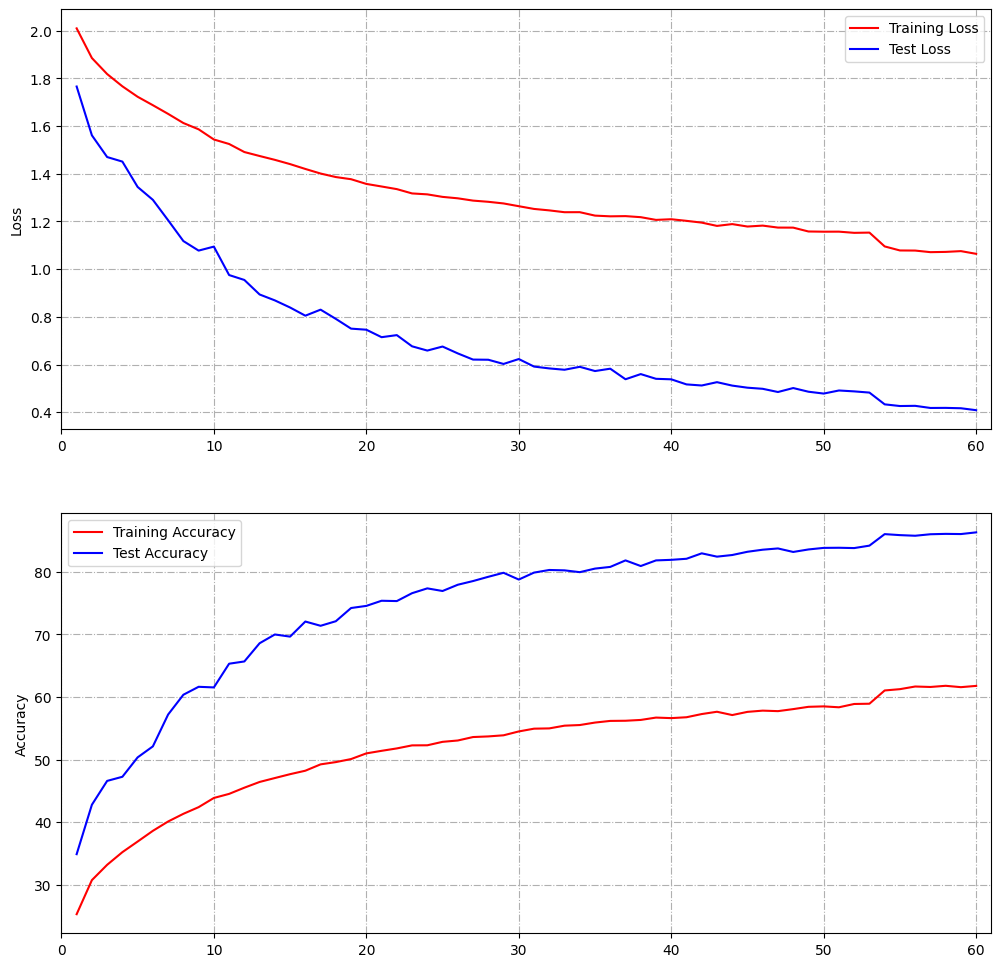

In [79]:
## use function from utils.py
plot_accuracy_losses(train_losses, train_acc, test_losses, test_acc, best_epoch)

## Error analysis

total wrong predictions: 1368


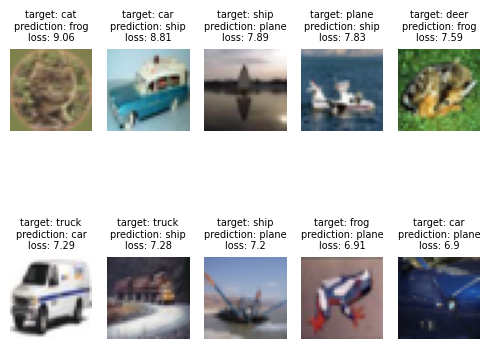

In [68]:
incr_groups_df = plot_top_loss(model, device, test_loader, criterion,
                               label_names = class_labels, img_rows=2, img_cols = 5)

In [69]:
incr_groups_df.loc[incr_groups_df.image > 1]

,target,prediction,loss,image
35,dog,cat,1.639356,117
19,cat,dog,1.402014,112
2,bird,deer,1.656625,47
6,bird,plane,1.360032,45
65,plane,ship,1.760245,42
...,...,...,...,...
0,bird,car,3.299157,2
40,dog,ship,1.826956,2
62,plane,dog,4.394076,2
43,frog,car,2.917746,2
